## Squeeze and excitation block(https://arxiv.org/abs/1709.01507) in ResNet architecture.
### В этой тетрадке мы снова будем эксперементировать с ResNet-ом и разнообразными блоками. Но для начала давайте поговорим о конволюциях.
### У операции конволюции есть один недостаток: даже на последних слоях, receptive field каждого пикселя в карте будет меньше размером, чем исходное изображения, а значит при получении этого пикселя была учтена не вся пространственная и канальная информация.
### Блок Squeeze and excitation использует информацию о всем исходном изображении на всех этапах обучения. Это происходит благодоря двум частям, которые дополняют обычный ResNet блок.
<img src='pictures/se_block.png'>
____________
## __Squeeze block__ 
#### В этом блоке происходит объединение карт признаков по средствам gloabl average pooling'a, то есть считается среднее по каждой карте и на выходе получается вектор из признаков с описанием карт. Этот вектор содержит глобальную информацию о картах, позволяя получать информацию сразу же о всем изображении.
<img src='pictures/squeeze.png'>
## __Excitation block__
#### Если squeeze блок выявлял пространственные корреляции, то данный блок отвечает за объединение информации из разных каналов . Это делается по стредствам полносвязных слоев с активациями.
#### Для того, чтобы не сильно увеличиавать количество параметров, формируется bottleneck, который уменьшает количество весов.
<img src='pictures/exictation.png'>
### После прохождения блоков, описанных выше, мы получаем вероятности (Так как последняя активация-сигмойда), которые можно интерпретировать по разному, мы же будем говорить о том, что они выражают важность данной карты. То есть, чем меньше вероятность, тем меньше будут значения в данной карте, а значит, они скорее всего будут меньше влиять на выход сети.

In [1]:
import os
import sys

import time
import blosc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqn
from IPython.display import clear_output

%matplotlib inline

sys.path.append('..')
import utils
from task_08.resnet_model import ResNet
from dataset import B,V,F
from dataset.dataset.opensets import MNIST

### Load data

In [2]:
dset = MNIST()

ExtractingExtractingExtractingExtracting   /tmp/t10k-images-idx3-ubyte.gz /tmp/t10k-labels-idx1-ubyte.gz/tmp/train-labels-idx1-ubyte.gz
/tmp/train-images-idx3-ubyte.gz




### train models 

In [3]:
plt.style.use('seaborn-poster')
plt.style.use('ggplot')

In [4]:
IMAGE_SIZE = 28
BATCH_SIZE = 100
NUM_ITERS = 200

In [5]:
placeholders_config = {
                       'images': {'shape': (IMAGE_SIZE, IMAGE_SIZE, 1),
                                 'dtype': 'float32',
                                 'data_format': 'channels_last',
                                 'name': 'reshaped_images'},
                
                       'labels': {'shape': (10),
                                 'dtype': 'int32',
                                 'data_format': 'channels_last',
                                 'transform': 'ohe',
                                 'name': 'targets'}
                       }

In [6]:
Bottlenet_config = {
    'inputs': placeholders_config,
    'input_block_config': {'layout': 'cna', 'filters': 64, 'kernel_size': 7, 'strides': 2},
    'filters':  [64, 128, 256, 512],
    'length_factor': [3, 1, 0, 0],
    'strides': [2, 1, 1, 1],
    'layout': 'ca',
    'bottleneck':True,
    'loss': 'ce',
    'dropout_rate': 0.2,
    'optimizer': {'name':'Adam', 'use_locking': True}}

SE_config = {**Bottlenet_config,
                     'se_block': [16, 16, 16, 16]}

In [7]:
placehold_dict = {'images': B('images'),
                  'labels': B('labels')}

In [11]:
bottle_tr_ppl = (dset.train
           .p
           .init_variable('bo_tr_acc', init_on_each_run=list)
           .init_model('dynamic',
                      ResNet,
                      'bottle',
                      config=Bottlenet_config)
           .train_model('bottle',
                        fetches='accuracy',
                        feed_dict=placehold_dict,
                        save_to=V('bo_tr_acc'), mode='a'))
bottle_te_ppl = (dset.test
           .p
           .init_variable('bottle_te_acc', init_on_each_run=list)
           .import_model('bottle', bottle_tr_ppl)
           .predict_model('bottle',
                        fetches='accuracy',
                        feed_dict=placehold_dict,
                        save_to=V('bottle_te_acc'), mode='a'))

In [12]:
se_tr_ppl = (dset.train
                    .p
                    .init_variable('se_tr_acc', init_on_each_run=list)
                    .init_model('dynamic',
                               ResNet,
                               'se',
                               config=SE_config)
                    .train_model('se',
                                fetches='accuracy',
                                feed_dict=placehold_dict,
                                save_to=V('se_tr_acc'), mode='a'))
se_te_ppl = (dset.test
                    .p
                    .init_variable('se_te_acc', init_on_each_run=list)
                    .import_model('se', se_tr_ppl)
                    .predict_model('se',
                                  fetches='accuracy',
                                  feed_dict=placehold_dict,
                                  save_to=V('se_te_acc'), mode='a'))

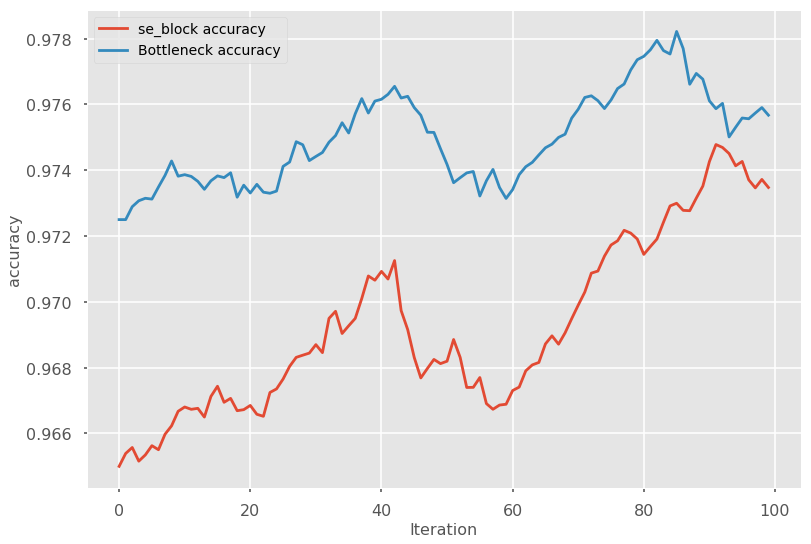

In [13]:
for i in tqn(range(500)):
    se_tr_ppl.next_batch(400, n_epochs=None, shuffle=True)
    se_te_ppl.next_batch(400, n_epochs=None, shuffle=True)
    bottle_tr_ppl.next_batch(400, n_epochs=None, shuffle=True)
    bottle_te_ppl.next_batch(400, n_epochs=None, shuffle=True)
    if i%10==0 and i != 0:
        clear_output(True)
        se_tr_acc = se_tr_ppl.get_variable('se_tr_acc')
        Bottle_tr_acc = bottle_tr_ppl.get_variable('bo_tr_acc')
        utils.draw(se_tr_acc[-100:], 'se_block', Bottle_tr_acc[-100:], 'Bottleneck', type_data='accuracy')
        plt.show()

### Выведем график loss функции в процессе обучения

../utils.py:48: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  firt_ewma = ewma(np.array(first), span=window, adjust=False)
../utils.py:49: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  second_ewma = ewma(np.array(second), span=window, adjust=False) if second else None


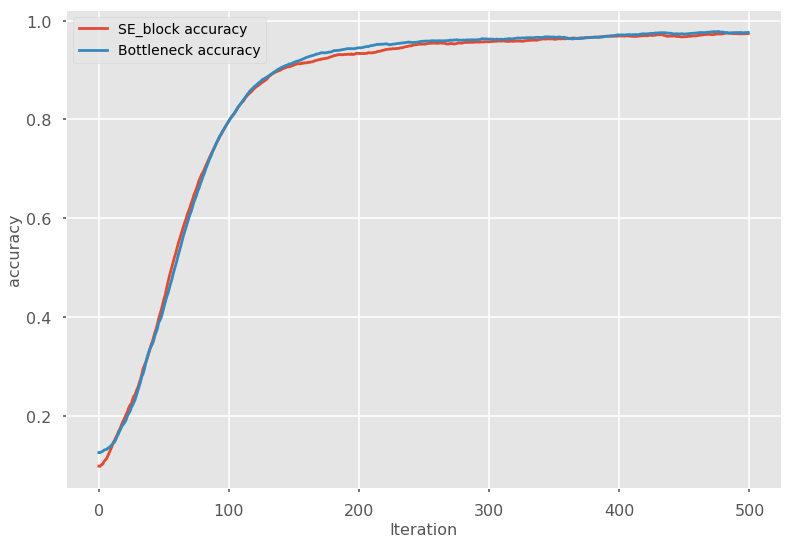

In [15]:
utils.draw(se_tr_acc, 'SE_block', Bottle_tr_acc, 'Bottleneck', type_data='accuracy')

### Для более точного анализа, выведем последние 200 итераций.

../utils.py:48: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  firt_ewma = ewma(np.array(first), span=window, adjust=False)
../utils.py:49: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  second_ewma = ewma(np.array(second), span=window, adjust=False) if second else None


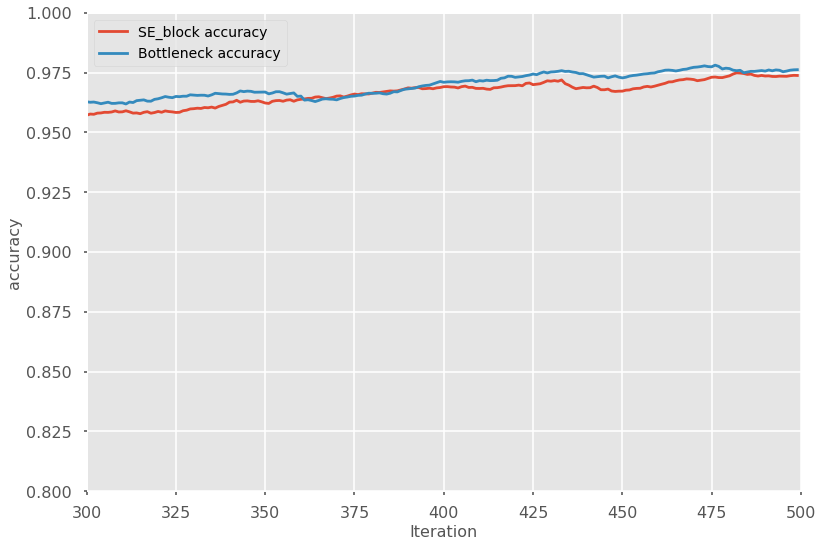

In [17]:
utils.draw(se_tr_acc, 'SE_block', Bottle_tr_acc, 'Bottleneck', type_data='accuracy', bound=[300, 500, 0.8, 1])

### По графикам видно, что SE блоки действительно дают прирост в качестве моделей и, в принципе не сильно влияют на скорость обучения. Благодоря bottleneck-у количество параметров в SE_ResNet'e(23994378 параметров) не сильно превышает обычный ResNet(23495690 параметров).

### seresnet

In [ ]:
col = sns.color_palette("Set2", 8) + sns.color_palette(["#9b59b6", "#3498db"])

def draw_avgpooling(maps, ppl, model=True):
    ppl.next_batch(500)
    answers = np.argmax(maps['answers'][0], axis=-1)
    indices = np.array([np.where(answers == i)[0] for i in range(10)])

    filters = np.array([np.mean(maps['avgpool'][0][indices[i]], axis=0).reshape(-1) for i in range(10)])
    for i in range(10):
        plt.plot(ewma(filters[i], span=350, adjust=False), color=col[i], label=str(i))

    plt.title("Distribution of average pooling in " + ("SE ResNet" if model else 'simple ResNet'))
    plt.legend(fontsize=16, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylabel('Activation', fontsize=18)
    plt.xlabel('Filter index', fontsize=18)
    plt.axis([0, 2060, 0, 1.])
    plt.show()

In [ ]:
maps_se = {'avgpool':[], 'answers':[]}
maps_bo = {'avgpool':[], 'answers':[]}

get_se_ppl = (dset.test
                .p
                .import_model('seresnet', train_pipeline)
                .get_maps_se([images, labels],  maps_se))

get_bo_ppl = (dset.test
                .p
                .import_model('bottlenet', train_pipeline)
                .get_maps_bo([images, labels],  maps_bo))

In [ ]:
draw_avgpooling(maps_se, get_se_ppl)
draw_avgpooling(maps_bo, get_bo_ppl, False)

###  На графиках выше показаны распределения карт(фильтров) после Global Average Pooling-a в конце сети. По оси X - номер карты, по оси Y - усредненное значение в картах одного класса после GAP. Всего представленно 10 различных графиков, которые показывают распределения карт одного из классов. 
### Не трудно заметить, что распределение у SE ResNet'a обладает гораздо большей дисперсией. Что же это значит?
### Если активации фильтров различных классов расположенны далеко друг от друга, значит для незнакомой картинки, после прохождения всей сети будет легче предсказать класс, чем если бы распределения всех классов были слеплены в одну кучу.
### Расширение дисперсии происходит за счет наличия полносвязных слоев, которые, как говорилось выше, работают с канальными признаками. Аггрегируя информацию по каналам полносвязные слои выделяют разнообразные признаки, присущие различным классам, тем самым влияя на конечный ответ.